In [1]:
import numpy as np
from scipy import stats
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from sklearn import preprocessing
from pysr import pysr, best, get_hof, best_callable, best_tex

In [2]:
def inverse_sample_decorator(dist):
    def wrapper(pnts, x_min, x_max, nbins, n=1e5, v=0, **kwargs):
        x = np.linspace(x_min, x_max, int(n))
        cumulative = np.cumsum(dist(x, **kwargs))
        r_x = x * (13**0.5)
        scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
        cumulative = scaler.fit_transform(cumulative.reshape(-1, 1))
        cumulative = cumulative.reshape(int(n))
        cdf = interp1d(r_x, cumulative)
        bins = np.linspace(1,7,nbins+1)
        cdf_bins = cdf(bins)[1:] - cdf(bins)[:-1]
        if v:
            plt.yscale("log")
            plt.scatter(r_x, cumulative, label="CDF")
            plt.scatter(r_x, dist(x, **kwargs), label="PDF")
            plt.scatter(cumulative, r_x, label="iCDF")
            plt.legend()
            plt.show()
        real_low = (cumulative).min()
        real_high = (cumulative).max()
        ff = interp1d(cumulative, x)
        return ff(np.random.uniform(low=real_low, high=real_high, size=pnts)), cdf_bins
    return wrapper

In [3]:
# Experimenting with Eq2
@inverse_sample_decorator
def f(x,ts=[1.1,1.2,1.3,1.4], nbins=60):
    xx = x/(13)**0.5
    v = ts[0] * ((1-xx)**(ts[1])) * (xx**ts[2]) * (xx**(ts[3]*np.log(xx)))
    return v

In [4]:
def of(x,ts=[1.1,1.2,1.3,1.4],nbins=60):
    xx = x/(13)**0.5
    v = ts[0] * ((1-xx)**(ts[1])) * (xx**ts[2]) * (xx**(ts[3]*np.log(xx)))
    return v

In [5]:
NBINS = 60
NE = 100000  # number of events per parametric
NP = 10000   # number of different parametrics

In [6]:
def eventRescale(x, r, nbins):
    x = np.array(x)
    x.reshape(nbins)
    scaler = preprocessing.MinMaxScaler(feature_range=r)
    x = scaler.fit_transform(x.reshape(-1,1))
    x = x.reshape(nbins)
    return x

In [7]:
def prob2event(x, r, nbins):
    x = np.array(x)
    x.reshape(nbins)
    scaler = preprocessing.MinMaxScaler(feature_range=r)
    x = (x * NE) 
    x = scaler.fit_transform(x.reshape(-1,1))
    x = x.reshape(nbins)
    return x

In [8]:
def data_gen(pmin, pmax, na, nb, f, nbins=60, scaled=False, pdf=False):
    init = True
    for i in range(nb):
        tsx = np.random.uniform(low=pmin,high=pmax,size=4)
        samples, y = f(na,ts=tsx,nbins=60,x_min=1/(13**0.5),x_max=7/(13**0.5))
        samples *= (13**0.5)
        n, bins = np.histogram(samples, bins=nbins)
            
        if scaled:
            n = eventRescale(n, (0,1), nbins)
            
        if init:
            X = np.array(n)
            Y = np.array(y)
            binsc = 0.5*(bins[1:] + bins[:-1]) 
            init = False
        else:
            X = np.vstack((X,n))
            Y = np.vstack((Y,y))
            
    if pdf:
        return X,Y,binsc,pdf(binsc/(13**0.5)),tsx
    
    return X,Y,binsc

In [9]:
GEN = False
import h5py
if GEN:
    X,Y,binsc= data_gen(1.2,1.8,100000,10000,f,scaled=True)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    Y = Y.reshape(Y.shape[0], Y.shape[1], 1)

    hf = h5py.File("bg-parametric.h5","w")
    hf.create_dataset("sample", data=X)
    hf.create_dataset("bin prob", data=Y)
    hf.close()
else:
    hf = h5py.File("bg-parametric.h5","r")
    X = np.array(hf.get("sample"))
    Y = np.array(hf.get("bin prob"))
    
    bins = np.linspace(1,7,NBINS+1)
    binsc = 0.5*(bins[1:] + bins[:-1]) 
    
print(X.shape, Y.shape)

(10000, 60, 1) (10000, 60, 1)


In [10]:
def plot2(binsc, X, Y):
    plt.style.use("dark_background")
    plt.grid()
    plt.yscale("log")
    plt.ylim((10**-4,10**0))
    plt.xlabel("m[TeV]")
    plt.ylabel("Events per bin")
    plt.scatter(binsc,X, s=6, label="sample", c="cyan")
    plt.scatter(binsc,prob2event(Y, (0,1), NBINS), s=6, label="bin prob", c="orange")
    plt.legend()
    plt.show()

In [11]:
def plot3(binsc, X, Y, Z):
    """
        X = events; Y = bin probability; Z = pdf rescaled to 0,1 
    """
    plt.style.use("dark_background")
    plt.grid()
    plt.yscale("log")
    plt.ylim((10**-4,10**0))
    plt.xlabel("m[TeV]")
    plt.ylabel("Events per bin")
    plt.scatter(binsc,X,s=6, label="sample", c="cyan")
    plt.scatter(binsc,prob2event(Y, (0,1), NBINS), s=6, label="bin prob", c="orange")
    plt.scatter(binsc,eventRescale(Z, (0,1), NBINS),s=6, label="pdf", c="pink")
    plt.legend()
    plt.show()

In [12]:
def plot4(binsc, X, Y, Z, F):
    """
        X = events; Y = bin probability; Z = pdf rescaled to 0,1; F = fit with pdf 
    """
    plt.style.use("dark_background")
    plt.grid()
    plt.yscale("log")
    plt.ylim((10**-4,10**0))
    plt.xlabel("m[TeV]")
    plt.ylabel("Events per bin")
    plt.scatter(binsc,X,s=6, label="sample", c="cyan")
    plt.scatter(binsc,prob2event(Y, (0,1), NBINS), s=6, label="bin prob", c="orange")
    plt.scatter(binsc,eventRescale(Z, (0,1), NBINS),s=6, label="pdf", c="pink")
    plt.scatter(binsc,eventRescale(F, (0,1), NBINS),s=6, label="pdf fit", c="red")
    plt.legend()
    plt.show()

[1.45873336 1.36535363 1.44763253 1.23009319]


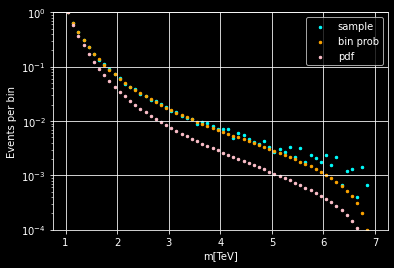

[1.64562455 1.2195823  1.63777416 1.24247858]


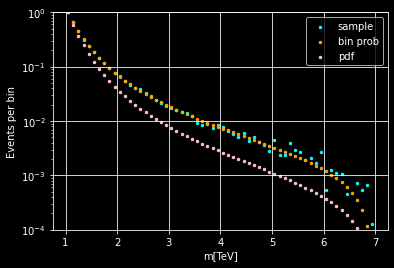

[1.43725633 1.43330011 1.62377923 1.4699398 ]


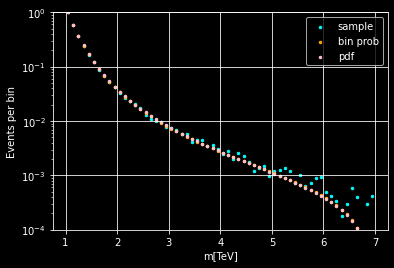

[1.69374478 1.77884547 1.36941552 1.28444293]


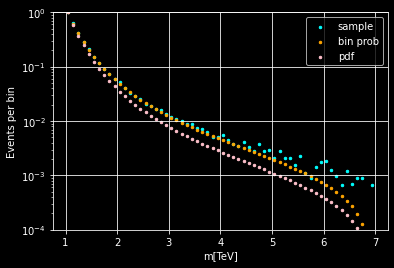

[1.69299835 1.28797546 1.40947598 1.24239172]


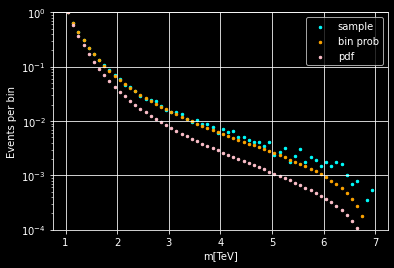

[1.51556423 1.55355838 1.34024511 1.73883181]


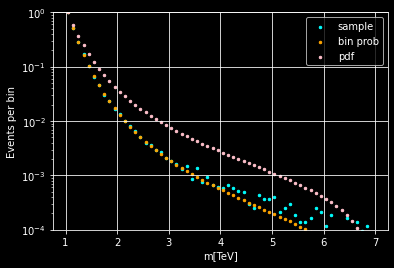

[1.57618151 1.66195115 1.6539212  1.67481921]


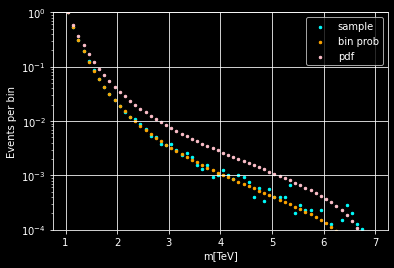

[1.24285943 1.33671552 1.47022543 1.28521814]


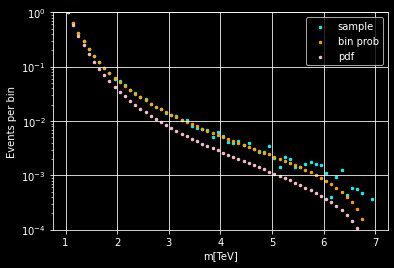

[1.20970221 1.61476611 1.66724899 1.4518257 ]


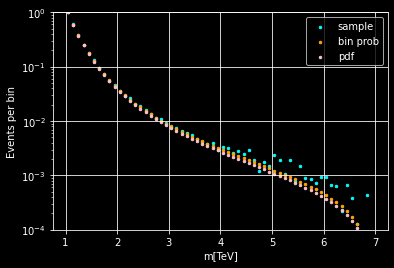

[1.56076014 1.39633097 1.480167   1.42247697]


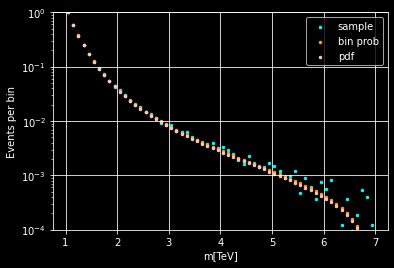

In [13]:
for i in range(10):
    X_test,Y_test,binsc,Z_test,tsx = data_gen(1.2,1.8,NE,1,f,scaled=True, pdf=of)
    print(tsx)
    plot3(binsc, X_test, Y_test, Z_test)

In [14]:
# Try fit CDF with PDF
def fof(x,a,b,c,d):
    xx = x/(13)**0.5
    v = a * ((1-xx)**(b)) * (xx**c) * (xx**(d*np.log(xx)))
    return v

[1.31043569 1.29600998 1.62284439 1.29413513]
[0.38930437 6.427588   3.26784076 1.53321807]


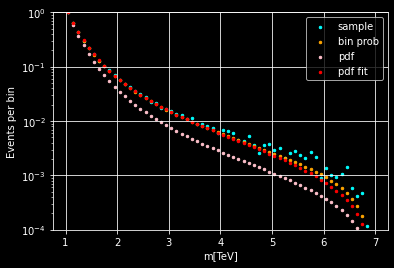

[1.76778343 1.71366386 1.56691488 1.79297735]
Failed to fit samples with PDF


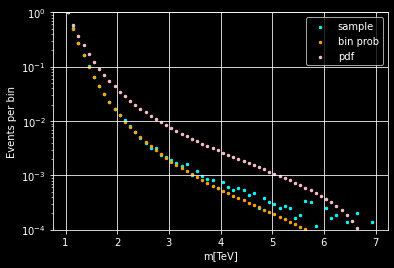

[1.42397222 1.36761948 1.66645542 1.57503139]
Failed to fit samples with PDF


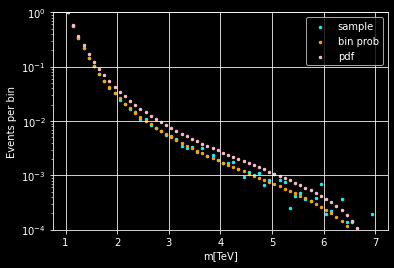

[1.47108275 1.39778181 1.42487968 1.29628621]
[0.25090393 6.35910359 3.19449049 1.5725303 ]


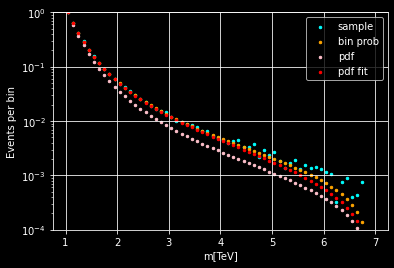

[1.47499202 1.30035889 1.31269332 1.54977659]
[0.91811929 9.28891859 5.21625659 2.20999378]


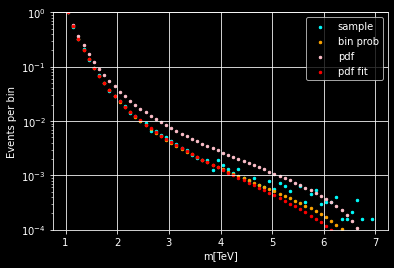

[1.67087184 1.48147943 1.73676683 1.25823249]
[0.06084152 4.15434016 1.81765003 1.21991968]


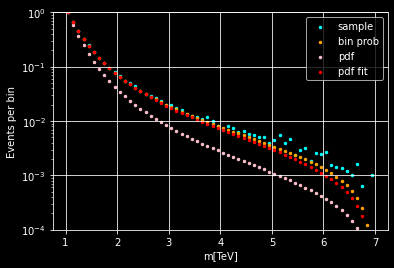

[1.77307823 1.2922481  1.3732199  1.78284435]
Failed to fit samples with PDF


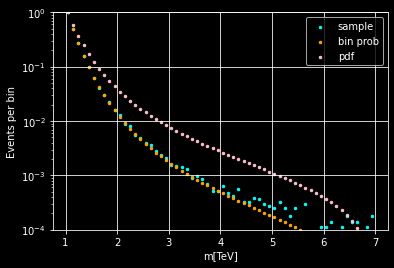

[1.26299809 1.55794561 1.66478789 1.35819053]
[0.03204764 4.21955314 1.87245746 1.34395062]


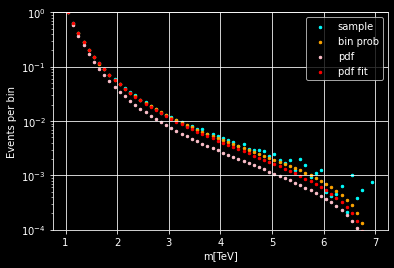

[1.38434919 1.6188768  1.59864266 1.35521971]
[0.47556567 6.93893782 3.82067388 1.72840173]


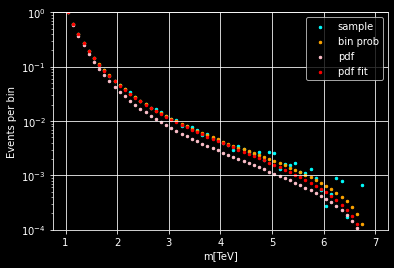

[1.25766048 1.58483434 1.68935206 1.51893631]
[0.15475292 6.23297235 3.7282917  1.85933577]


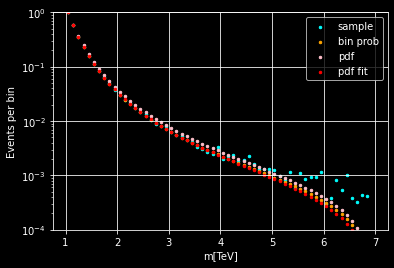

[1.26281683 1.749444   1.51741669 1.75370033]
Failed to fit samples with PDF


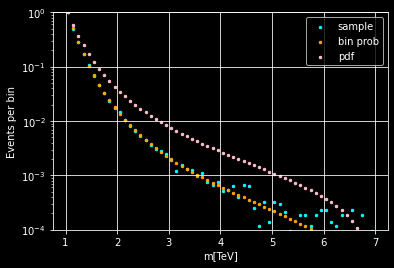

[1.20191916 1.28800592 1.53903866 1.48464358]
[0.01244653 4.08587343 1.85884237 1.48591269]


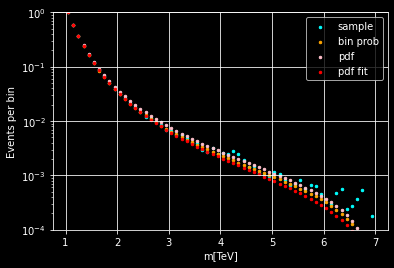

[1.63511007 1.79395421 1.28660139 1.48083979]
Failed to fit samples with PDF


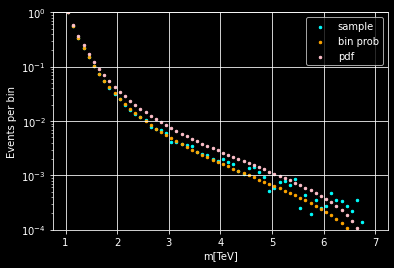

[1.35086083 1.32478196 1.51286643 1.5078165 ]
[0.05708267 5.61540708 3.06888806 1.74666473]


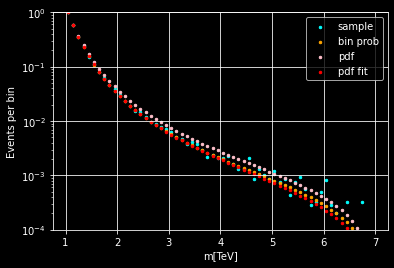

[1.74597807 1.37138684 1.22968789 1.72771578]
Failed to fit samples with PDF


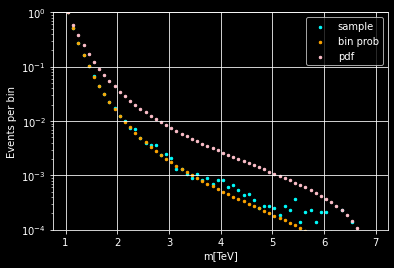

[1.41011057 1.75308381 1.73403836 1.29912933]
[1.37574341 7.76779257 4.08941985 1.67806165]


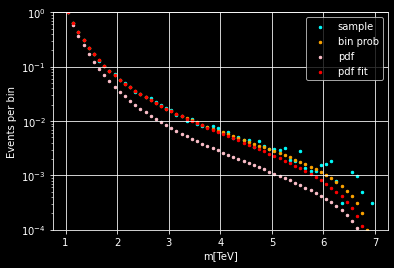

[1.6292394  1.64251446 1.50356808 1.51249243]
[0.23879518 7.04973536 4.11236574 1.95421769]


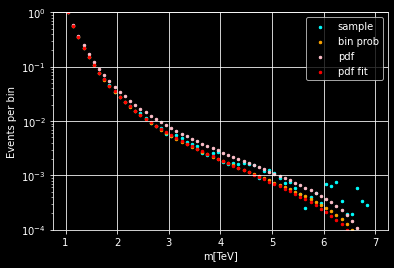

[1.71069634 1.785848   1.33777781 1.44371698]
[0.13759607 6.86654585 3.5111098  1.80005757]


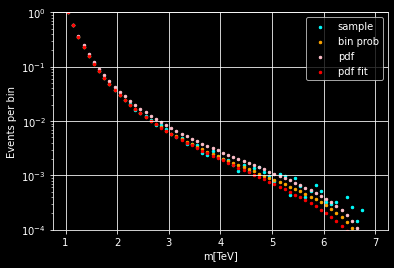

[1.39718507 1.77138745 1.22381525 1.39422043]
[0.18025179 7.08574921 3.55892258 1.77929415]


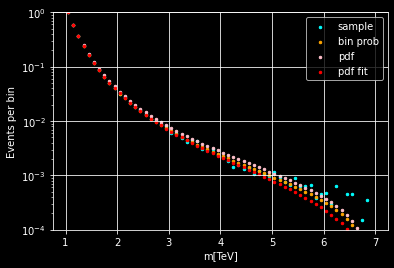

[1.6311634  1.50749369 1.5226498  1.43283099]
[0.13882231 6.05005564 3.36239212 1.72857162]


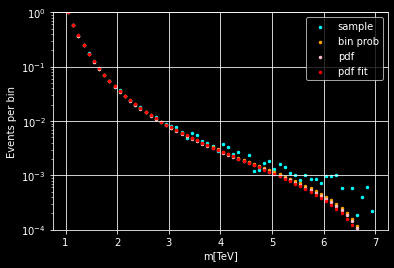

In [15]:
from scipy.optimize import curve_fit
for i in range(20):
    X_test,Y_test,binsc,Z_test,tsx = data_gen(1.2,1.8,NE,1,f,scaled=True, pdf=of)
    print(tsx)
    try:
        popt, pcov = curve_fit(fof, binsc/(13**0.5), X_test)
        print(popt)
        F_test = fof(binsc/(13**0.5), *popt)
        plot4(binsc, X_test, Y_test, Z_test, F_test)
    except RuntimeError:
        print("Failed to fit samples with PDF")
        plot3(binsc, X_test, Y_test, Z_test)

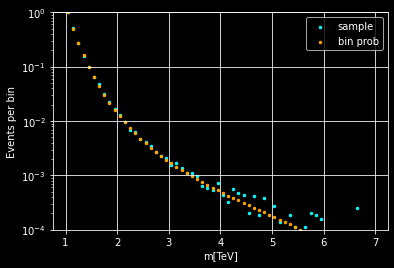

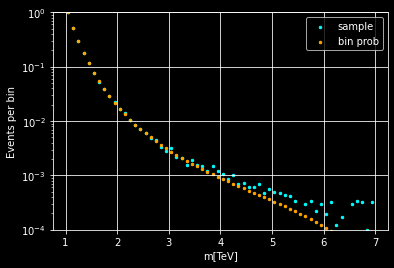

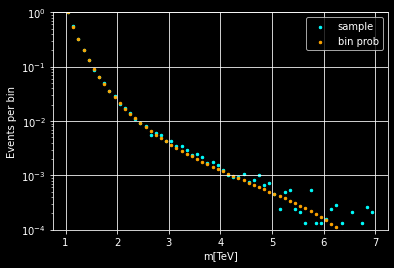

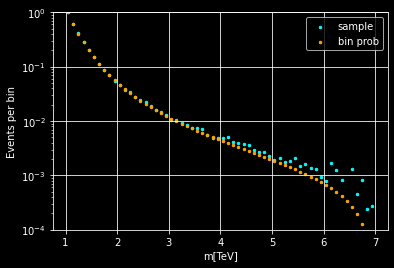

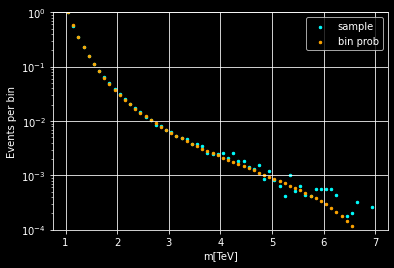

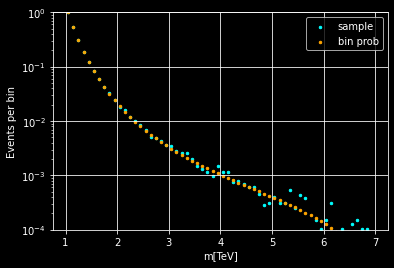

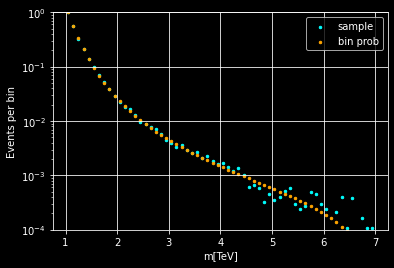

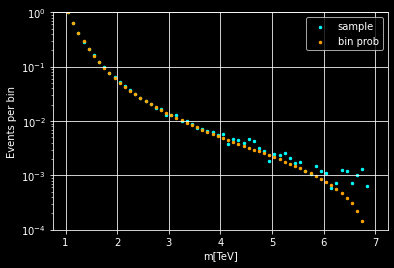

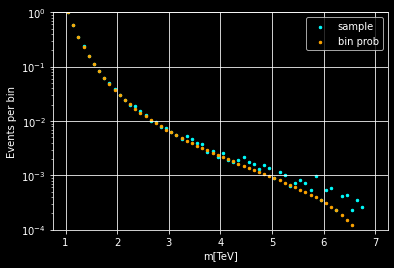

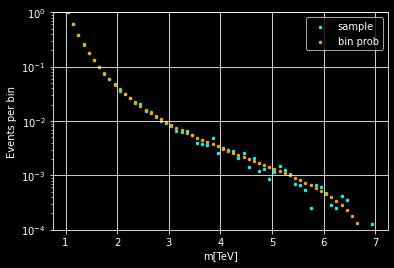

In [17]:
# Check data
for i in np.random.randint(NP, size=10):
    plot2(binsc, X[i,:], Y[i,:])

In [22]:
# Try Symbolic Regression

In [23]:
print(Y.shape)

(10000, 60, 1)


In [24]:
X_test,Y_test,binsc= data_gen(1.2,1.8,NE,1,f,scaled=True)
#xx = np.linspace(1,10,num=60)
#yy = np.exp(-xx)
X_sr = np.zeros((NP, NBINS))
W_sr = np.zeros((NP, NBINS))
Y_srs = X[:,:,0]
Y_srp = Y[:,:,0]
for i in range(NP):
    W_sr[i] = Y_test[::-1]
    X_sr[i] = binsc
print(X_sr.shape, Y_srs.shape, Y_srp.shape, W_sr.shape)

(10000, 60) (10000, 60) (10000, 60) (10000, 60)


In [25]:
print(X_sr.flatten().shape)
print(Y_srs.flatten().shape)
print(Y_srp.flatten().shape)
print(W_sr.flatten().shape)

(600000,)
(600000,)
(600000,)
(600000,)


In [26]:
N = 120
equations_sample = pysr(X_sr.flatten()[:N], Y_srs.flatten()[:N], weights=W_sr.flatten()[:N],
                        niterations=5, binary_operators=["plus", "sub", "mult", "pow"],
                        unary_operators=["exp","logm"])

equations_prob = pysr(X_sr.flatten()[:N], Y_srp.flatten()[:N], weights=W_sr.flatten()[:N],
                        niterations=5, binary_operators=["plus", "sub", "mult", "pow"],
                        unary_operators=["exp","logm"])

Running on julia -O3 -p 4 /tmp/tmp4z0qypyp/runfile.jl
Started!

Cycles per second: 2.400e+04
Progress: 4 / 20 total iterations (20.000%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           7.758e-04  0.000e+00  0.002176
5           1.767e-06  1.217e+00  pow(sub(x0, 0.04682927), -4.6206627)
13          8.758e-07  8.774e-02  pow(sub(mult(mult(x0, pow(x0, 0.26768786)), x0), pow(0.12435931, x0)), -1.8981462)
15          8.023e-07  4.384e-02  pow(sub(mult(mult(x0, pow(x0, 0.26768786)), x0), pow(0.12435931, pow(x0, x0))), -1.8981462)
17          4.533e-07  2.855e-01  pow(mult(x0, pow(0.9751338, 1.8786774)), sub(-2.4931302, sub(1.6477358, pow(-0.6835324, pow(sub(x0, 0.60660744), 2.7304478)))))


Cycles per second: 1.800e+04
Progress: 6 / 20 total iterations (30.000%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           7.758e-04  0.000e+00  0.002176
5           1.767e-06  1.217e+

In [56]:
def testsr1(lowp, highp, equations, sorp, ne=NE, plot=True, random=False, nbins=NBINS, n=N):
    if random:
        X_test,Y_test,binsc = data_gen(lowp,highp,ne,1,f,scaled=True)
    else:
        X_test = np.average(Y_srs[:n//nbins], axis=0)
        Y_test = np.average(Y_srp[:n//nbins], axis=0)
        binsc = X_sr.flatten()[:nbins]

    print(best(equations))
    print(best_tex(equations))
    Y_hat = best_callable(equations)(binsc)
    print(sum(Y_hat))
    
    if plot:
        plt.grid()
        plt.ylim((10**-4,10**0))
        plt.yscale("log")
        plt.scatter(binsc,X_test, s=6, label="sample",c="cyan")
        plt.scatter(binsc, prob2event(Y_test, (0,1), NBINS), s=6, label="true bin prob", c="orange")
        if sorp == "p":
            plt.scatter(binsc, prob2event(Y_hat, (0,1), NBINS), s=6, 
                        label="SR predict bin prob", c="red")
        elif sorp == "s":
            plt.scatter(binsc, Y_hat, s=6, 
                        label="SR predict sample", c="red")
            
        plt.xlabel("m[TeV]")
        plt.ylabel("Events per bin")
        plt.title("Symbolic Regression Test on Parametric ({},{})".format(lowp, highp))
        plt.legend()
        plt.show()
        
    return X_test, Y_test, Y_hat

Piecewise((0, Eq(x0, 0)), (x0*(0.95221245*Abs(x0))**(-0.3269829**(x0 - 1.33776) - 4.043129)/Abs(x0), True))
\begin{cases} 0 & \text{for}\: x_{0} = 0 \\\frac{x_{0} \left(0.95221245 \left|{x_{0}}\right|\right)^{- 0.3269829^{x_{0} - 1.33776} - 4.043129}}{\left|{x_{0}}\right|} & \text{otherwise} \end{cases}
3.3966248772888594


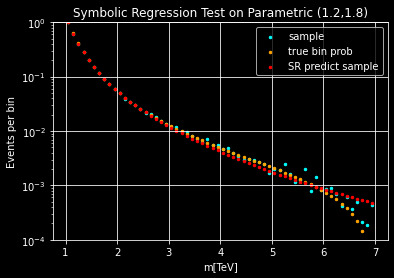

In [57]:
_ = testsr1(1.2, 1.8, equations_sample, "s")

Piecewise((0.0008035456, Ne(x0, 0) & Ne(x0*Abs(x0)**(0.9087128**(-0.2814962**log(Abs(x0)) + x0) - 1), 0) & (Eq(x0, 0) | Eq(x0*Abs(x0)**(0.9087128**(-0.2814962**log(Abs(x0)) + x0) - 1), 0))), (8.52245533828588, Eq(x0, 0) | Eq(x0*Abs(x0)**(0.9087128**(-0.2814962**log(Abs(x0)) + x0) - 1), 0)), (0.0008035456, Ne(x0, 0) & Ne(x0*Abs(x0)**(0.9087128**(-0.2814962**log(Abs(x0)) + x0) - 1), 0) & (Eq(x0, 0) | Eq(x0*Abs(x0)**(0.9087128**(-0.2814962**log(Abs(x0)) + x0) - 1), 0) | Eq(6.41506807690787*0.05760037**(x0*Abs(x0**0.194736)*Abs(x0)**(0.9087128**(-0.2814962**log(Abs(x0)) + x0) + 0.194736*re(0.9087128**(-0.2814962**log(Abs(x0)))*0.9087128**x0) - 1.194736)), 0))), (17.3609995908012**(re(x0*Abs(x0)**(0.9087128**(-0.2814962**log(Abs(x0)) + x0) + 0.194736*re(0.9087128**(-0.2814962**log(Abs(x0)))*0.9087128**x0) - 1.194736))*Abs(x0**0.194736))*(0.0008035456*0.05760037**(re(x0*Abs(x0)**(0.9087128**(-0.2814962**log(Abs(x0)) + x0) + 0.194736*re(0.9087128**(-0.2814962**log(Abs(x0)))*0.9087128**x0) - 1

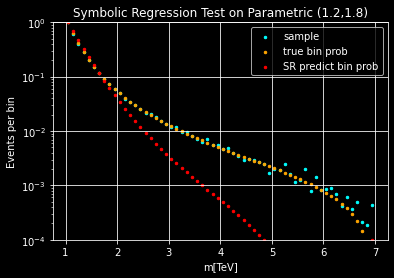

In [49]:
_ = testsr1(1.2, 1.8, equations_prob, "p")

In [31]:
def train_testsr1(lowp, highp, ne=NE, plot=True):
    X_test,Y_test,binsc= data_gen(lowp,highp,ne,1,f,scaled=True)
    W_sr = Y_test[::-1]
    print(binsc.shape)
    print(X_test.shape)
    print(Y_test.shape)
    print(W_sr.shape)

    equations_prob = pysr(binsc, Y_test, weights=W_sr.flatten()[:N],
                        niterations=5, binary_operators=["plus", "sub", "mult", "pow"],
                        unary_operators=["exp","logm"])
    
    equations_sample = pysr(binsc, X_test, weights=W_sr.flatten()[:N],
                        niterations=5, binary_operators=["plus", "sub", "mult", "pow"],
                        unary_operators=["exp","logm"])

    for i, equations in enumerate([equations_prob, equations_sample]):
        print(best(equations))
        print(best_tex(equations))
        Y_hat = best_callable(equations)(binsc)
        print(sum(Y_hat))

        if plot:
            plt.grid()
            plt.ylim((10**-4,10**0))
            plt.yscale("log")
            plt.scatter(binsc,X_test, s=6, label="sample",c="cyan")
            plt.scatter(binsc, prob2event(Y_test, (0,1), NBINS), s=6, label="true bin prob", c="orange")
            if i: labelx = "bin prob"
            else: labelx = "sample"
            plt.scatter(binsc, prob2event(Y_hat, (0,1), NBINS), s=6, label="SR predict "+labelx, c="red")
            plt.xlabel("m[TeV]")
            plt.ylabel("Events per bin")
            plt.title("Symbolic Regression Test on Parametric ({},{})".format(lowp, highp))
            plt.legend()
            plt.show()
        
    return X_test, Y_test, Y_hat

(60,)
(60,)
(60,)
(60,)
Running on julia -O3 -p 4 /tmp/tmp_5tbouvv/runfile.jl
Started!

Cycles per second: 2.400e+04
Progress: 4 / 20 total iterations (20.000%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           5.693e-05  0.000e+00  0.000596
14          1.046e-06  2.855e-01  exp(mult(x0, sub(pow(pow(0.052066315, x0), plus(x0, -0.27606177)), mult(x0, x0))))
16          9.731e-07  3.616e-02  exp(mult(x0, sub(pow(pow(0.052066315, x0), mult(x0, plus(x0, -0.27606177))), mult(x0, x0))))
18          9.604e-07  6.605e-03  exp(mult(x0, sub(pow(pow(0.052066315, x0), mult(mult(x0, x0), plus(x0, -0.27606177))), mult(x0, x0))))
19          5.510e-07  5.555e-01  pow(mult(plus(x0, mult(plus(x0, mult(pow(pow(-0.11126771, x0), x0), 2.3437507)), x0)), x0), sub(-0.3578022, x0))
21          4.074e-07  1.510e-01  pow(mult(plus(x0, mult(plus(x0, mult(pow(pow(-0.11126771, x0), x0), 2.3437507)), x0)), x0), sub(mult(1.1219829, -0.36236113), x0))


Cyc

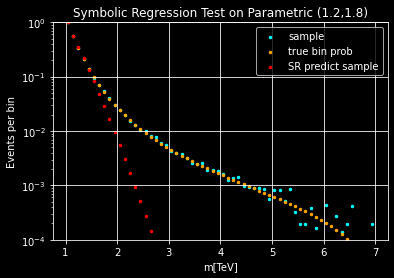

Piecewise((0, Eq(x0, 0.048500597) | Eq((x0 - 0.048500597)/Abs((x0 - 0.048500597)**54.82944), 0)), ((x0 - 0.048500597)/Abs((x0 - 0.048500597)**6.847925394192), True))
\begin{cases} 0 & \text{for}\: x_{0} = 0.048500597 \vee \frac{x_{0} - 0.048500597}{\left|{\left(x_{0} - 0.048500597\right)^{54.82944}}\right|} = 0 \\\frac{x_{0} - 0.048500597}{\left|{\left(x_{0} - 0.048500597\right)^{6.847925394192}}\right|} & \text{otherwise} \end{cases}
2.5922128787905714


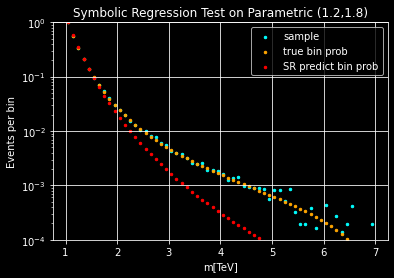

In [33]:
_ = train_testsr1(1.2,1.8)